# Training and testing the model

* Open all the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt 

In [2]:
Df = pd.read_csv('./DataSets/PreProcessed_EnergyConsumption_WeatherData.csv', header=0)
Df.head()

,Time,Energy Usage,t,tp,rf,wr,wg,wsr,wsg,regen,ldred,ldstat,sonne
0,2021-01-27 11:00:00,8.03,0.0,-3.8,75.0,130.0,3.6,NaN,7.6,0.0,1018.4,973.5,93.0
1,2021-01-27 12:00:00,6.85,1.9,-3.3,68.0,150.0,5.4,NaN,9.4,0.0,1017.7,973.1,66.0
2,2021-01-27 13:00:00,8.86,3.5,-2.8,63.0,190.0,7.6,NaN,11.2,0.0,1016.8,972.5,100.0
3,2021-01-27 14:00:00,7.37,4.4,-5.3,49.0,120.0,9.4,NaN,14.8,0.0,1016.3,972.1,99.0
4,2021-01-27 15:00:00,7.67,5.0,-7.6,40.0,150.0,5.4,NaN,11.2,0.0,1015.5,971.5,100.0


In [3]:
DfH = pd.read_csv('./DataSets/EnergyReading_Days_Dataset.csv', header=0)
DfH.head()

,Time,Holiday,Week Day,Energy Usage,cos_x,sin_x
0,2021-01-27 11:00:00,0.0,2,8.03,-0.222521,0.974928
1,2021-01-27 12:00:00,0.0,2,6.85,-0.222521,0.974928
2,2021-01-27 13:00:00,0.0,2,8.86,-0.222521,0.974928
3,2021-01-27 14:00:00,0.0,2,7.37,-0.222521,0.974928
4,2021-01-27 15:00:00,0.0,2,7.67,-0.222521,0.974928


### Merge the holidays and week day decoding 

In [4]:
Df.insert(1,'Holiday',DfH["Holiday"])
Df.insert(1,'Cos',DfH["cos_x"])
Df.insert(1,'Sin',DfH["sin_x"])
Df.insert(1,'Week Day',DfH["Week Day"])

In [5]:
Df =Df.reindex(columns=["Time","Sin","Cos","Holiday","t","Energy Usage"])

### Splitting the Time 

The datetime feature should be splitted into separate features as year,month,day,hour

In [6]:
from datetime import datetime as dt 
def SplitTime(data,col): 
    
    year = [] 
    month = [] 
    day = [] 
    hour = [] 
    
    for str_date in data[col]: 
        dti = dt.strptime(str_date, "%Y-%m-%d %H:%M:%S")
        year.append(dti.year)
        month.append(dti.month)
        day.append(dti.day)
        hour.append(dti.hour)
   
    #Delete the old column
    data.drop(col, inplace = True, axis=1) 

    #Insert the newone
    data.insert(0, 'year',year)
    data.insert(1, 'month',month)
    data.insert(2, 'day',day)
    data.insert(3, 'hour',hour)

    return data

CDf= SplitTime(Df,'Time')

In [7]:
Df.to_csv("./DataSets/DataSet_complete.csv",index=False)

### Creating Lookback columns 

In [8]:
def create_lookback_columns(df, label, num_lookback_samples):
    for lookback in range(1,num_lookback_samples):
        df[f"{label} Lookback {lookback}"] = [0 for i in range(lookback)] + [df[label][i-lookback] for i in range(lookback,df.shape[0])]


In [9]:
use_autorecursive = False
lookback_samples = 6
lookback_label = 't'
create_lookback_columns(Df, lookback_label, lookback_samples)
Df = Df[lookback_samples:]

Y = Df['Energy Usage']
lookback_labels = [f"{lookback_label} Lookback {lookback}" for lookback in range(1, lookback_samples)]
X_train_original = Df[["month","day","hour","Sin","Cos",'Holiday','t'] + lookback_labels]
if use_autorecursive:
    X_test = Df[["month","day","hour","Sin","Cos",'Holiday','t']]
else:
    X_test = Df[["month","day","hour","Sin","Cos",'Holiday','t'] + lookback_labels]



### The data Frame now is ready to be used

Each column would be a feature for the machine learning model. 
The index now starts at 6 since we've implemented the lookback. It would be impossible to have lookback samples features for the first measurement. Thus, our first sample that will be used as a feature is the sample 6 (the samples before are still used but as a lookback parameter)

In [10]:
Df.head()

,year,month,day,hour,Sin,Cos,Holiday,t,Energy Usage,t Lookback 1,t Lookback 2,t Lookback 3,t Lookback 4,t Lookback 5
6,2021,1,27,17,0.974928,-0.222521,0.0,2.1,7.21,2.5,5.0,4.4,3.5,1.9
7,2021,1,27,18,0.974928,-0.222521,0.0,-1.1,6.01,2.1,2.5,5.0,4.4,3.5
8,2021,1,27,19,0.974928,-0.222521,0.0,-1.6,3.42,-1.1,2.1,2.5,5.0,4.4
9,2021,1,27,20,0.974928,-0.222521,0.0,-1.2,6.16,-1.6,-1.1,2.1,2.5,5.0
10,2021,1,27,21,0.974928,-0.222521,0.0,-1.9,3.82,-1.2,-1.6,-1.1,2.1,2.5


# Machine learning models

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns #Tool for ML
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #Performance metrics to ML 
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

### Split Test and Training Data 

20% of data will be used a verification (test) data and the remaining data will be used to train the models. This distribution in each cluster is random.

In [12]:
from sklearn.model_selection import train_test_split
if use_autorecursive:
    X_train, _, y_train, _ = train_test_split(X_train_original, Y, test_size=0.2, random_state=42)
    _, X_test, _, y_test = train_test_split(X_test, Y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train,y_test = train_test_split(X_train_original, Y, test_size=0.2, random_state=42)

X_train = X_train.values

## Linear Regression

### Training the model

In [13]:
LinearReg = LinearRegression(normalize=True)
LinearReg.fit(X_train, y_train)

LinearRegression(normalize=True)

### Testing the model 

* Model perfomance with the testing set 

In [14]:
from collections import deque
def autorecursive_prediction(model, x_test, y0, num_lookback_samples, use_autorecursive=False):
    if use_autorecursive:
        y_prev = deque([0 for i in range(num_lookback_samples)], maxlen=num_lookback_samples-1)
        ys = []
        for row in x_test.values:
            x_test_cur = np.expand_dims(np.append(row,y_prev),axis=0)
            y_cur = model.predict(x_test_cur)
            ys.append(y_cur)
            y_prev.append(y_cur)
        return np.array(ys)
    else:
        return model.predict(x_test)

In [15]:
LinearPred = autorecursive_prediction(LinearReg, X_test, Y.head(), lookback_samples, use_autorecursive)

LinearRMSE = (np.sqrt(mean_squared_error(y_test, LinearPred)))
LinearR2= max(r2_score(y_test, LinearPred),-100)
LinearMAE = mean_absolute_error(y_test, LinearPred)

print('RMSE is {:.4f}'.format(LinearRMSE))
print('R2 score is {:.4f}'.format(LinearR2))

RMSE is 1.3158
R2 score is 0.4834


* Plotting real value vs predicted values 

<Figure size 432x288 with 0 Axes>

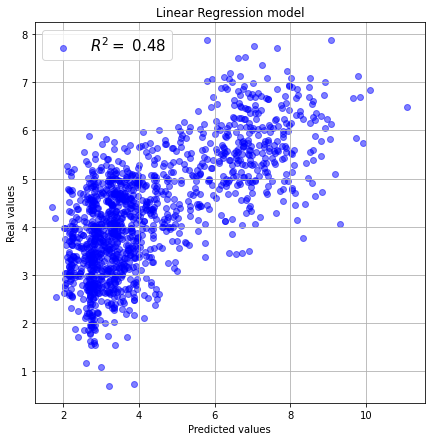

In [16]:
plt.figure()
plt.figure(figsize=(7, 7))
plt.grid()
plt.scatter(y_test,LinearPred,alpha=0.5,
            color='blue',label=r'$R^2 = $ {:.2f}'.format(LinearR2))
plt.title("Linear Regression model")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})
plt.savefig("./Imgs/linear_regression_model.png",transparent=True)
plt.show()

 We could conclude that this model is not the indicated for this prediction. We've got a low $R^2$ and with the plot we could see that the real values and the predicted ones are not matching. 
 Seems like for the most of the real values the model has an output of a value between 2 and 4, and also other cluster between 6 and 8

## Decision Tree Regressor model 

* Model training

In [17]:
DecTreeReg= DecisionTreeRegressor(criterion="mse",min_samples_split= 60)
DecTreeReg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', min_samples_split=60)

* Model testing

In [18]:
DTRPred = autorecursive_prediction(DecTreeReg, X_test, 
                                Y.head(),lookback_samples, use_autorecursive)

* Model perfomance

In [19]:
DTRRMSE = (np.sqrt(mean_squared_error(y_test, DTRPred)))
DTRR2= r2_score(y_test, DTRPred)
DTRMAE = mean_absolute_error(y_test, DTRPred)
print("Perfomance for testinG set {:.2f}".format(DTRR2))

Perfomance for testinG set 0.91


<Figure size 432x288 with 0 Axes>

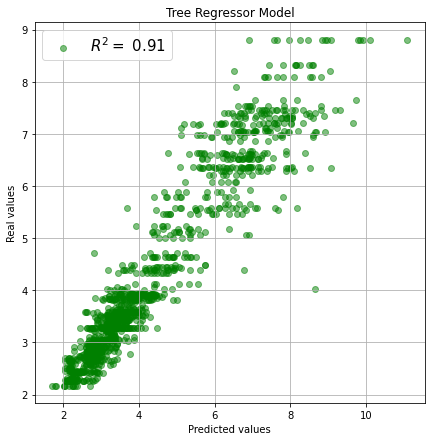

In [20]:
plt.figure()
plt.figure(figsize=(7, 7))
plt.grid()
plt.scatter(y_test,DTRPred,alpha=0.5
        ,color='green',label=r'$R^2 = $ {:.2f}'.format(DTRR2))
plt.title("Tree Regressor Model")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})
plt.savefig("./Imgs/tree_regressor_model.png",transparent=True)
plt.show()

## MLPRegressor model 

* Model training

In [ ]:
MLPR_cv= MLPRegressor(hidden_layer_sizes=(400,20), activation='tanh', alpha=0.001, learning_rate='constant', solver='adam')
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
MLRPRMSE = []
MLPRR2 = []
MLPRMAE = []
train_best = []
test_best =[]
X_train_original = X_train_original.reset_index(drop=True)
Y_reset = Y.reset_index(drop=True)

for train_indices, test_indices in kf.split(X_train_original):
    MLPR_cv.fit(X_train_original.iloc[train_indices], Y_reset.iloc[train_indices])
    MLPRPred = autorecursive_prediction(MLPR_cv, X_train_original.iloc[test_indices], Y.iloc[0],lookback_samples, use_autorecursive)
    MLRPRMSE.append(np.sqrt(mean_squared_error(Y_reset.iloc[test_indices], MLPRPred)))
    r2 = r2_score(Y_reset.iloc[test_indices], MLPRPred)
    if len(MLPRR2) !=0:
        if r2 > MLPRR2[-1]:
            train_best = train_indices
            test_best = test_indices
    MLPRR2.append(r2)
    MLPRMAE.append(mean_absolute_error(Y_reset.iloc[test_indices], MLPRPred))
    print(MLPR_cv.score(X_train_original.iloc[test_indices], Y_reset.iloc[test_indices]))

print("Best R2 is", np.max(MLPRR2))
print("Best MRSE is", np.min(MLRPRMSE))
print("Best MAE is", np.min(MLPRMAE))

0.7462857197668351
0.856742842619468
0.781552056528253
0.1506082826268066
0.7018998516208815
0.6508899163380726
0.8287260663886613
0.7731895049141295


* Model testing

In [ ]:
MLPR = MLPRegressor(hidden_layer_sizes=(400,20), activation='tanh', alpha=0.001, learning_rate='constant', solver='adam')
MLPR.fit(X_train_original.iloc[train_best], Y_reset.iloc[train_best])

#MLPRPred=MLPR.predict(X_test)
MLPRPred = autorecursive_prediction(MLPR, X_train_original.iloc[test_best], Y.head(),lookback_samples, use_autorecursive)

In [ ]:
MLRPRMSE = (np.sqrt(mean_squared_error(y_test, MLPRPred)))
MLPRR2= r2_score(y_test, MLPRPred)
MLPRMAE = mean_absolute_error(y_test, MLPRPred)
print(MLPRR2)

In [ ]:
plt.figure()
plt.figure(figsize=(7, 7))
plt.grid()
plt.scatter(y_test,MLPRPred,alpha=0.5
        ,color='#ff00c9',label=r'$R^2 = $ {:.2f}'.format(MLPRR2))
plt.title("MLPR regressor")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})
plt.savefig("./Imgs/MLPR_regressor_model.png",transparent=True)
plt.show()

* Model perfomance

## SVR regressor model 

In [ ]:
from sklearn.svm import SVR

* Training the model 

In [ ]:
SVRregressor = SVR(gamma=0.01)
SVRregressor.fit(X_train, y_train)

* Test the model

In [ ]:
SVRPred = autorecursive_prediction(SVRregressor, X_test, Y.head(),
                                   lookback_samples, use_autorecursive)

In [ ]:
SVRRMSE = (np.sqrt(mean_squared_error(y_test, SVRPred)))
SVRR2= r2_score(y_test, SVRPred)
SVRMAE = mean_absolute_error(y_test, SVRPred)

print(SVRR2)

In [ ]:
plt.figure()
plt.figure(figsize=(7, 7))
plt.grid()
plt.scatter(y_test,SVRPred,alpha=0.5
        ,color='#FF5733',label=r'$R^2 = $ {:.2f}'.format(SVRR2))
plt.title("SVR")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})
plt.savefig("./Imgs/SVLR_regressor_model.png",transparent=True)
plt.show()

## Model comparation

In [ ]:
plt.figure()
plt.figure(figsize=(15, 15))

#Linear Regression 
plt.subplot(2,2,1)
plt.grid()
plt.scatter(y_test,LinearPred,alpha=0.5,
            color='blue',label=r'$R^2 = $ {:.2f}'.format(LinearR2))
plt.title("Linear Regression")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})

# Decision Tree Regressor model 
plt.subplot(2,2,2)
plt.grid()
plt.scatter(y_test,DTRPred,alpha=0.5
        ,color='green',label=r'$R^2 = $ {:.2f}'.format(DTRR2))
plt.title("Decision Tree Regression")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})

#MLPR
plt.subplot(2,2,3)
plt.grid()
plt.scatter(y_test,MLPRPred,alpha=0.5
        ,color='#ff00c9',label=r'$R^2 = $ {:.2f}'.format(MLPRR2))
plt.title("MLPR")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})

#SVRR
plt.subplot(2,2,4)
plt.grid()
plt.scatter(y_test,SVRPred,alpha=0.5
        ,color='#FF5733',label=r'$R^2 = $ {:.2f}'.format(SVRR2))
plt.title("SVR")
plt.ylabel("Real values")
plt.xlabel("Predicted values")
plt.legend(prop={'size': 15})
plt.savefig("./Imgs/ModelComp.png",transparent=True)

plt.show()


### Performance comparation 

To decide which model has the best perfomance we compare these measurements: 

* $R^2$ : Coefficient of determination. Represents the proportion of the variance in the dependent variable that the independt variables (our inputs variables) explain collectively. It's a measure that indicates how well our model fit.

* $MAE$ : Mean Absolute Error. Represents the average of the absolute difference between the actual and predicted values

* $RMS$ : Root Mean Squared Error. Represents the standard deviation of residuals.

In [ ]:
serie_1 = [406, 387, 442, 457, 485]
serie_2 = [421, 453, 435, 478, 512]
 
RMSList = [LinearRMSE, DTRRMSE, SVRRMSE, MLRPRMSE]
MAEList = [LinearMAE, DTRMAE, SVRMAE, MLPRMAE]
R2List = [LinearR2, DTRR2, SVRR2, MLPRR2]
BarIdx = np.arange(0,8,2)
BarWidth=0.35
 
fig = plt.figure(figsize=(10,8))
b1 = plt.bar(BarIdx , RMSList, width=BarWidth, label='RMS',color = "#af7ac5")
b2 = plt.bar(BarIdx + 1.1*BarWidth, MAEList, width=BarWidth, label='MAE',color= "#5499c7")
b3 = plt.bar(BarIdx + 2.2*BarWidth, R2List, width=BarWidth, label='$R^2$',color = "#48c9b0")

#Text values in top of each bar
for ax in b1 + b2 + b3:
    height = ax.get_height()
    plt.text(ax.get_x() + ax.get_width()/2.0, height, "{:.2f}".format(height), 
             ha='center', va='bottom')



plt.legend(loc='best')

plt.xticks(BarIdx + BarWidth, ('Linear', 'DTR', 'SVR', 'MLPR'))
 
plt.ylabel('Value')
plt.xlabel('ML Model')
plt.title("Models' Perfomance")
plt.grid()
plt.savefig("./Imgs/Model_perfomance.png",transparent=True)
plt.show()

Based on $R^2$ value (the most appropriate one to compare different models) the best model for this particular case is the **Decision Tree Regressor**

# Using the model 

### Gathering features DataFrame 

* Open Forecast data

In [ ]:
Df = pd.read_csv("./DataSets/Preprocessed_Forecast_DataSet.csv")
Df.head()

* Changing column names to match the one we've used at model training

In [ ]:
Df.insert(3,"Sin",Df["sin_x"])
Df.insert(4,"Cos",Df["cos_x"])
Df.head()

* Delete the old named column

In [ ]:
Df= Df.drop("sin_x",axis=1)
Df = Df.drop("cos_x",axis=1)

### Predict the energy consumption with DTR

In [ ]:
#predictions=DecTreeReg.predict(Df)
predictions = autorecursive_prediction(DecTreeReg, Df, Y.head(),lookback_samples, use_autorecursive)

* Save predictions into the data frame

In [ ]:
Df.insert(7,"Energy usage",predictions)

* Put all date info together and convert it to datetime objects 

We'll use this for easier plotting

In [ ]:
def Convertstr2dt(data,col): 
    dates=[]
    for idx,value in enumerate(data[col]): 
        str_date = '2021-' + str(data['month'][idx])+ '-' + str(data['day'][idx])+ ' ' + str(data['hour'][idx])
        dti = dt.strptime(str_date, "%Y-%m-%d %H")
        dates.append(dti)
   
    #Delete the old column
    data.drop('month', inplace = True, axis=1) 
    data.drop('day', inplace = True, axis=1) 
    data.drop('hour', inplace = True, axis=1) 
    #Insert the newone
    data.insert(0, 'Time',dates)
    return data

Df = Convertstr2dt(Df,'month')

In [ ]:
Df.head()

### Plots

In [ ]:
def Plotday(df,day, MonthNum,year=2021): 
    x = []
    y = [] 

    for idx,value in enumerate(df["Time"]):
        if value.month == MonthNum and value.day == day: 
            x.append(df["t"][idx])
            y.append(value.hour)
            #print(value.hour)
            
    if not x and not y: 
        print("Missing day")
        return -1 
    
    fig=plt.figure(figsize=(15,8))
    plt.grid()
    plt.title("Daily Consumption" + ": " + str(day) + "/" + str(MonthNum))
    plt.plot(y,x,alpha=0.8, color='#d35400', lw="1",linestyle="--", marker="o",markersize=12)
    plt.xlabel("Hour")
    plt.ylabel("Energy KWh")
   
    plt.savefig("./Imgs/Prediction_EnergyConsumption_daily" + str(day)+ "_"+ str(MonthNum)+ ".png",transparent=True)

##### Plot the predicted consumption for a day

In [ ]:
Plotday(Df,23,11)

##### 4 days consumption prediction

* Find the index where the days change and setting the hours labels 

    To use them for labelling x axe

In [ ]:
x = []
y = [] 
Nhours = []  
HourChangeidx = [] 
DayChangeidx = []  
Nday = []
Nameday=[]

for idx, value in enumerate(Df["Time"]): 
    #if value.day == 23 or value.day == 24:
    if True: 
        x.append(Df["Energy usage"][idx])
        y.append(idx)
        HourChangeidx.append(idx)
        Nhours.append(value.hour)
    if Nday and Nday[-1] != value.day: 
        Nday.append(value.day)
        Nameday.append(value.strftime("%A"))
        DayChangeidx.append(idx)
        
    elif not Nday: 
        Nday.append(value.day)
        Nameday.append(value.strftime("%A"))
        DayChangeidx.append(idx)

* Whole forecast data plot 

In [ ]:
fig=plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plt.grid()
plt.title("Energy consumption prediction")
ax1.set_xticks(HourChangeidx)
ax1.set_xticklabels(Nhours, rotation=90)
ax1.plot(y,x,alpha=0.8, color='#d35400', 
         lw="1",linestyle="--", marker="o",markersize=10)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(DayChangeidx)
ax2.set_xticklabels(Nameday)

#plt.plot(Df["Energy usage"][:20].index,Df["Energy usage"][:20],alpha=0.8, color='orange', lw="0.75",linestyle="--", marker="o",markersize=8)
ax1.set_xlabel("Hours")
ax1.set_ylabel("Energy KWh")
plt.savefig("./Imgs/Prediction_Energy_consumption_4days.png",
                transparent=True)